In [13]:
from google.colab import drive
import os, zipfile

# Mount your Google Drive
drive.mount('/content/drive')

# Path to the uploaded zip file
zip_path = '/content/drive/MyDrive/MRI.zip'

# Extract the zip
extract_path = '/content/MRI'
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

# Set training and testing directory paths
train_dir = os.path.join(extract_path, 'Training')
test_dir = os.path.join(extract_path, 'Testing')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [14]:
import os

for folder in os.listdir('MRI'):
    print(folder)
    print(os.listdir(os.path.join('MRI', folder)))


Testing
['pituitary', 'glioma', 'meningioma', 'notumor']
Training
['pituitary', 'glioma', 'meningioma', 'notumor']


In [15]:
data_dir = 'MRI'  # Use this base path in your model pipeline


In [16]:
train_dir = os.path.join(data_dir, 'Training')
test_dir = os.path.join(data_dir, 'Testing')


In [17]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os


In [18]:
IMG_SIZE = 150
BATCH_SIZE = 32

train_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training'
)

val_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation'
)

test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)


Found 4571 images belonging to 4 classes.
Found 1141 images belonging to 4 classes.
Found 1311 images belonging to 4 classes.


In [19]:

model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(IMG_SIZE, IMG_SIZE, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),

    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Dropout(0.3),

    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Dropout(0.3),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(4, activation='softmax')  # 4 classes
])

# ✅ Compile before fitting
model.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)


In [25]:
from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(
    monitor='val_loss',
    patience=6,
    restore_best_weights=True,
    verbose=1
)

history = model.fit(
    train_generator,
    epochs=40,  # Try fewer epochs
    validation_data=val_generator,
    callbacks=[early_stop]
)



Epoch 1/40
143/143 ━━━━━━━━━━━━━━━━━━━━ 36s 252ms/step - accuracy: 0.9029 - loss: 0.2653 - val_accuracy: 0.8186 - val_loss: 0.5705
Epoch 2/40
143/143 ━━━━━━━━━━━━━━━━━━━━ 37s 259ms/step - accuracy: 0.8871 - loss: 0.3049 - val_accuracy: 0.8028 - val_loss: 0.5852
Epoch 3/40
143/143 ━━━━━━━━━━━━━━━━━━━━ 37s 259ms/step - accuracy: 0.9053 - loss: 0.2831 - val_accuracy: 0.8238 - val_loss: 0.5562
Epoch 4/40
143/143 ━━━━━━━━━━━━━━━━━━━━ 37s 258ms/step - accuracy: 0.9091 - loss: 0.2510 - val_accuracy: 0.8282 - val_loss: 0.5645
Epoch 5/40
143/143 ━━━━━━━━━━━━━━━━━━━━ 39s 275ms/step - accuracy: 0.8947 - loss: 0.2828 - val_accuracy: 0.8203 - val_loss: 0.5283
Epoch 6/40
143/143 ━━━━━━━━━━━━━━━━━━━━ 39s 277ms/step - accuracy: 0.9111 - loss: 0.2430 - val_accuracy: 0.8019 - val_loss: 0.6409
Epoch 7/40
143/143 ━━━━━━━━━━━━━━━━━━━━ 37s 255ms/step - accuracy: 0.9103 - loss: 0.2347 - val_accuracy: 0.8238 - val_loss: 0.5676
Epoch 8/40
143/143 ━━━━━━━━━━━━━━━━━━━━ 36s 250ms/step - accuracy: 0.9127 - loss: 0

In [26]:
loss, accuracy = model.evaluate(test_generator)
print(f"Test Accuracy: {accuracy:.2f}")


41/41 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - accuracy: 0.8697 - loss: 0.4459
Test Accuracy: 0.88


In [22]:
from google.colab import files

uploaded = files.upload()  # This will prompt you to browse and select a file


In [ ]:
import os

img_path = next(iter(uploaded))  # gets the file name of uploaded image
print("Image Path:", img_path)


Image Path: Te-no_0010.jpg


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


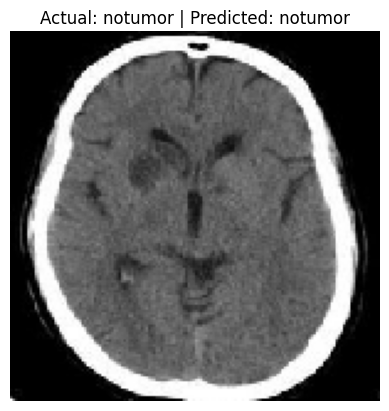

In [27]:
import numpy as np
import matplotlib.pyplot as plt
import os
from tensorflow.keras.preprocessing import image

# Define your image size and class labels (must match training)
IMG_SIZE = 150  # use 224 if your model used that
class_labels = ['glioma', 'meningioma', 'notumor', 'pituitary']

# === STEP 1: Set your image path ===
img_path = '/content/MRI/Testing/notumor/Te-no_0010.jpg'  # 🔁 Change this as needed

# === STEP 2: Load and preprocess image ===
img = image.load_img(img_path, target_size=(IMG_SIZE, IMG_SIZE))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0) / 255.0  # normalize

# === STEP 3: Predict with trained model ===
prediction = model.predict(img_array)
predicted_class = class_labels[np.argmax(prediction)]

# === STEP 4: Get actual label from folder name ===
actual_class = os.path.basename(os.path.dirname(img_path))

# === STEP 5: Display result ===
plt.imshow(img)
plt.title(f"Actual: {actual_class} | Predicted: {predicted_class}")
plt.axis('off')
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


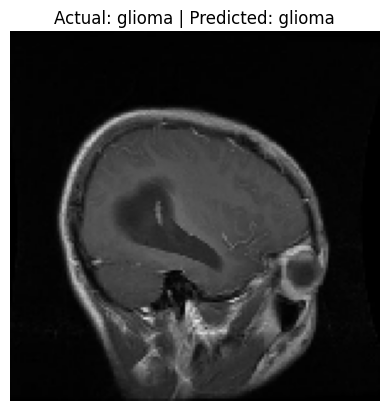

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


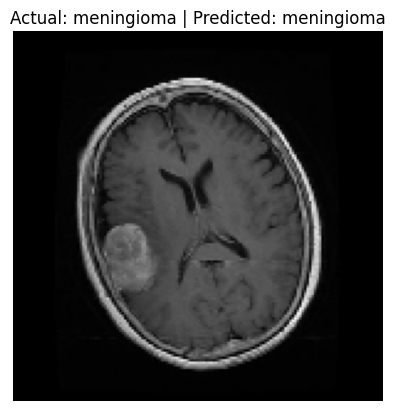

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


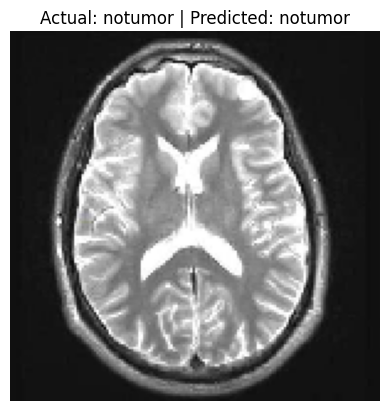

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


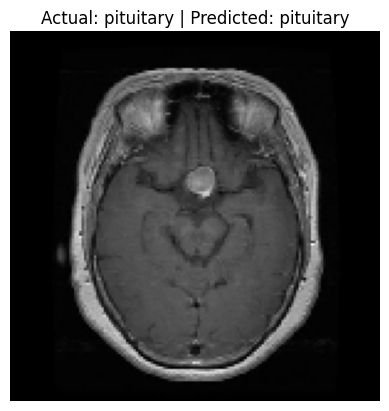

In [31]:
import os
import numpy as np
import matplotlib.pyplot as plt
import random
from tensorflow.keras.preprocessing import image

# Define test base path and class labels
test_base_path = '/content/MRI/Testing'
class_labels = ['glioma', 'meningioma', 'notumor', 'pituitary']
IMG_SIZE = 150  # Change to 224 if that's what your model uses

# Loop over each class
for label in class_labels:
    class_path = os.path.join(test_base_path, label)
    image_files = os.listdir(class_path)

    if not image_files:
        continue

    # ✅ Pick a random image from the folder
    random_image = random.choice(image_files)
    img_path = os.path.join(class_path, random_image)

    # Load and preprocess
    img = image.load_img(img_path, target_size=(IMG_SIZE, IMG_SIZE))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0) / 255.0

    # Predict
    prediction = model.predict(img_array)
    predicted_class = class_labels[np.argmax(prediction)]

    # Show result
    plt.imshow(img)
    plt.title(f"Actual: {label} | Predicted: {predicted_class}")
    plt.axis('off')
    plt.show()


In [32]:
model.save('/content/drive/MyDrive/brain_tumor_model.h5')
